<a href="https://colab.research.google.com/github/Marglodis/challenge2-data-science-LATAM/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Telecom X: Análisis de evasión de clientes

#📌 Extracción

In [372]:
url = 'https://raw.githubusercontent.com/Marglodis/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [374]:
sns.set(style="whitegrid")
%matplotlib inline

In [375]:
# Cargar los datos desde la API
# Cargar directamente como DataFrame
df = pd.read_json(url)

# MOstrar las primeras filas y forma del DataFrame
df
print(df.head())
print(df.shape)

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

#🔧 Transformación

In [376]:
# Desanidar el JSON y explorar estructura
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])
df_charges = pd.json_normalize(df['account'].apply(lambda x: x['Charges'] if 'Charges' in x else {}))

cols_to_drop = [col for col in df_account.columns if col.startswith('Charges')]

# Combinar todo en un solo DataFrame
df = pd.concat([
    df[['customerID', 'Churn']],
    df_customer,
    df_phone,
    df_internet,
    df_account.drop(columns=cols_to_drop),
    df_charges
], axis=1)

# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [377]:
# Verificacion de inconsistenicas y limpieza inicial
# VErificacion de duplicados
print("Valores duplicados", df.duplicated().sum())

# VErificar valores nulos
print("\nValores nulos\n", df.isnull().sum())

# Manejar valores vacíos en 'Churn' (reemplazar ' ' con 'No')
df['Churn'] = df['Churn'].replace('', 'No')

# Convertir 'Total' de (account.Charges) a float, manejar vacíos
df['Total'] = pd.to_numeric(df['Total'], errors='coerce').fillna(0)

# Renombrar columnas para claridad
df.rename(columns={'Monthly': 'MonthlyCharges', 'Total': 'TotalCharges'}, inplace=True)

# Convertir 'Yes/No' a 1/0 para variables binarias
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'PaperlessBilling']

for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Manejar categorías inconsistentes (e.g., 'No internet service' ya mapeado a 0 en el paso anterior)
# Verificar limpieza
print(df['Churn'].value_counts(normalize=True) * 100)
# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

Valores duplicados 0

Valores nulos
 customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Monthly             0
Total               0
dtype: int64
Churn
No     74.280996
Yes    25.719004
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           726

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


In [378]:
# Crear nueva columna Cuentas_Diarias
## Crear columna diaria (aprox. mensual /30) -> Proporciona una vista granular del gasto, útil para patrones temporales en churn.
df['Cuentas_Diarias'] = df['MonthlyCharges'] / 30

# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract          7267 non-null   object 


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667


#📊 Carga y análisis

In [379]:
# Descriptivo para numéricas
# Calcular describe en inglés
num_desc = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']].describe().T
# Diccionario de traducción para las métricas
traduccion = {
    'count': 'conteo',
    'mean': 'media',
    'std': 'desviación estándar',
    'min': 'mínimo',
    '25%': '25%',
    '50%': 'mediana (50%)',
    '75%': '75%',
    'max': 'máximo'
}

# Renombrar el índice de columnas (las métricas)
num_desc.rename(columns=traduccion, inplace=True)
# Eliminar la fila 'conteo' (era la columna 'count' original)
num_desc = num_desc.drop(columns=['conteo'])
# Redondear todos los valores a 2 decimales
num_desc = num_desc.round(2)
# Mostrar como tabla Markdown
print(num_desc.to_markdown())

|                 |   media |   desviación estándar |   mínimo |    25% |   mediana (50%) |     75% |   máximo |
|:----------------|--------:|----------------------:|---------:|-------:|----------------:|--------:|---------:|
| tenure          |   32.35 |                 24.57 |     0    |   9    |           29    |   55    |    72    |
| MonthlyCharges  |   64.72 |                 30.13 |    18.25 |  35.42 |           70.3  |   89.88 |   118.75 |
| TotalCharges    | 2277.18 |               2268.65 |     0    | 396.2  |         1389.2  | 3778.52 |  8684.8  |
| Cuentas_Diarias |    2.16 |                  1    |     0.61 |   1.18 |            2.34 |    3    |     3.96 |


In [380]:
# Proporciones categóricas
print(df['gender'].value_counts(normalize=True))
print(df['SeniorCitizen'].value_counts(normalize=True))
print(df['Partner'].value_counts(normalize=True))
print(df['Dependents'].value_counts(normalize=True))
print(df['PhoneService'].value_counts(normalize=True))
print(df['MultipleLines'].value_counts(normalize=True))
print(df['InternetService'].value_counts(normalize=True))
print(df['OnlineSecurity'].value_counts(normalize=True))
print(df['OnlineBackup'].value_counts(normalize=True))
print(df['DeviceProtection'].value_counts(normalize=True))
print(df['TechSupport'].value_counts(normalize=True))
print(df['StreamingTV'].value_counts(normalize=True))
print(df['StreamingMovies'].value_counts(normalize=True))
print(df['Contract'].value_counts(normalize=True))
print(df['PaperlessBilling'].value_counts(normalize=True))
print(df['PaymentMethod'].value_counts(normalize=True))
print(df['Churn'].value_counts(normalize=True))


gender
Male      0.505711
Female    0.494289
Name: proportion, dtype: float64
SeniorCitizen
0    0.837347
1    0.162653
Name: proportion, dtype: float64
Partner
0    0.515894
1    0.484106
Name: proportion, dtype: float64
Dependents
0    0.699876
1    0.300124
Name: proportion, dtype: float64
PhoneService
1    0.902711
0    0.097289
Name: proportion, dtype: float64
MultipleLines
No                  0.480941
Yes                 0.421770
No phone service    0.097289
Name: proportion, dtype: float64
InternetService
Fiber optic    0.440072
DSL            0.342370
No             0.217559
Name: proportion, dtype: float64
OnlineSecurity
0    0.71405
1    0.28595
Name: proportion, dtype: float64
OnlineBackup
0    0.655429
1    0.344571
Name: proportion, dtype: float64
DeviceProtection
0    0.657218
1    0.342782
Name: proportion, dtype: float64
TechSupport
0    0.710472
1    0.289528
Name: proportion, dtype: float64
StreamingTV
0    0.616073
1    0.383927
Name: proportion, dtype: float64
Strea

In [381]:
def churn_rate_by_cat(col):
    return df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)['Yes'] * 100

for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']:
    print(f"Churn rate por {col}:\n", churn_rate_by_cat(col).round(2))


Churn rate por gender:
 gender
Female    26.14
Male      25.31
Name: Yes, dtype: float64
Churn rate por SeniorCitizen:
 SeniorCitizen
0    22.89
1    40.27
Name: Yes, dtype: float64
Churn rate por Partner:
 Partner
0    32.01
1    19.02
Name: Yes, dtype: float64
Churn rate por Dependents:
 Dependents
0    30.34
1    14.95
Name: Yes, dtype: float64
Churn rate por InternetService:
 InternetService
DSL            18.45
Fiber optic    40.56
No              7.15
Name: Yes, dtype: float64
Churn rate por Contract:
 Contract
Month-to-month    41.32
One year          10.93
Two year           2.75
Name: Yes, dtype: float64
Churn rate por PaymentMethod:
 PaymentMethod
Bank transfer (automatic)    16.24
Credit card (automatic)      14.80
Electronic check             43.80
Mailed check                 18.50
Name: Yes, dtype: float64


In [382]:
# Distribución de Evasión (Churn) Visualizar la tasa de churn (~26% Yes), identificando el desbalance.
# Proporción de CHurn
churn_dist = df['Churn'].value_counts(normalize=True) * 100
print(churn_dist)
print(df['Contract'].value_counts(normalize=True) * 100)
print(df['PaymentMethod'].value_counts(normalize=True) * 100)
print(df['gender'].value_counts(normalize=True) * 100)

Churn
No     74.280996
Yes    25.719004
Name: proportion, dtype: float64
Contract
Month-to-month    55.112151
Two year          23.985138
One year          20.902711
Name: proportion, dtype: float64
PaymentMethod
Electronic check             33.645246
Mailed check                 22.911793
Bank transfer (automatic)    21.865969
Credit card (automatic)      21.576992
Name: proportion, dtype: float64
gender
Male      50.571075
Female    49.428925
Name: proportion, dtype: float64


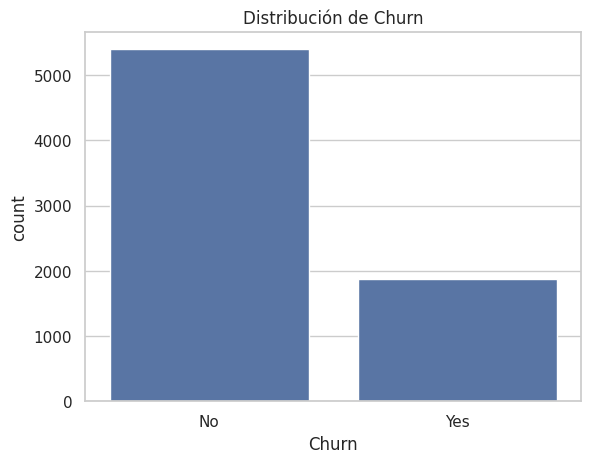

In [383]:
# Gráfico
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.show()

In [384]:
# --- 1. Asegurarse de que 'Churn' sea numérico para cálculos ---
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --- 2. Crear columnas categóricas para etiquetas en el eje X ---
# Convertir 0 → 'No', 1 → 'Yes' para columnas binarias
df['SeniorCitizen_label'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
df['Partner_label']       = df['Partner'].map({0: 'No', 1: 'Yes'})
df['Dependents_label']    = df['Dependents'].map({0: 'No', 1: 'Yes'})

# Mantener otras columnas tal cual
cat_cols = [
    'gender',
    'SeniorCitizen_label',  # ← ahora muestra 'No'/'Yes' en eje X
    'Partner_label',
    'Dependents_label',
    'InternetService',
    'Contract',
    'PaymentMethod'
]

# Diccionario para títulos bonitos
display_names = {
    'gender': 'Género',
    'SeniorCitizen_label': '¿Mayor de edad?',
    'Partner_label': '¿Tiene pareja?',
    'Dependents_label': '¿Tiene dependientes?',
    'InternetService': 'Servicio de Internet',
    'Contract': 'Tipo de contrato',
    'PaymentMethod': 'Método de pago'
}

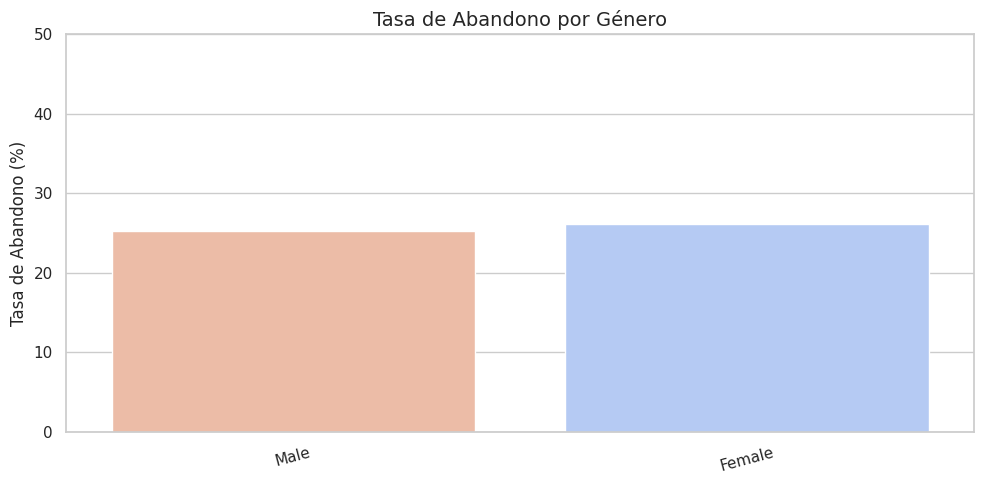

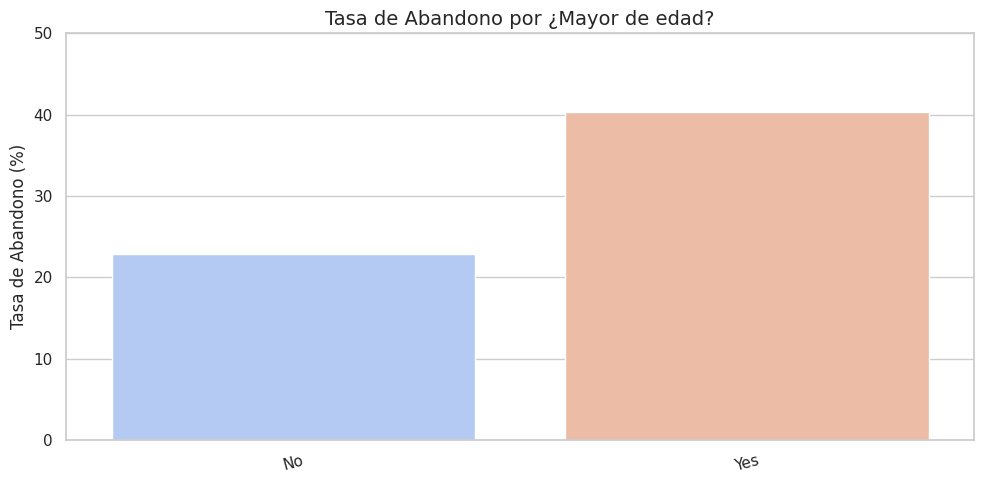

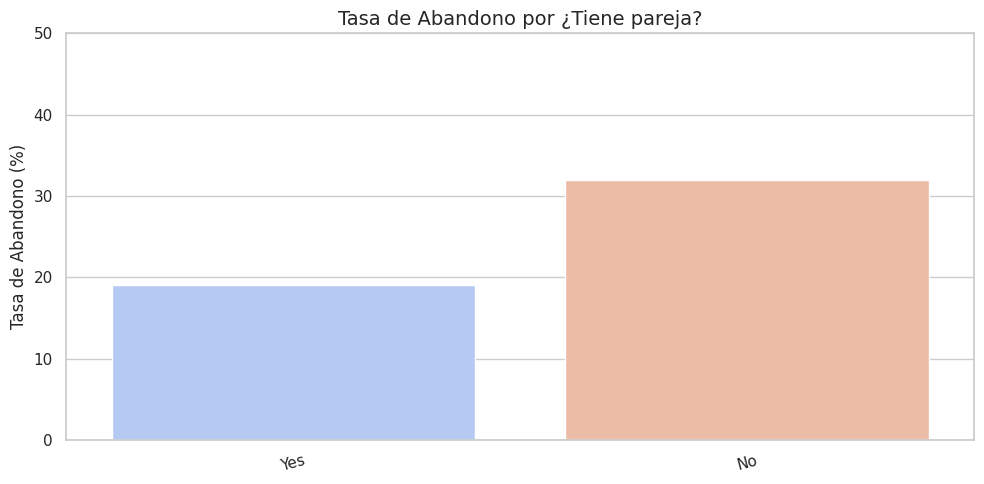

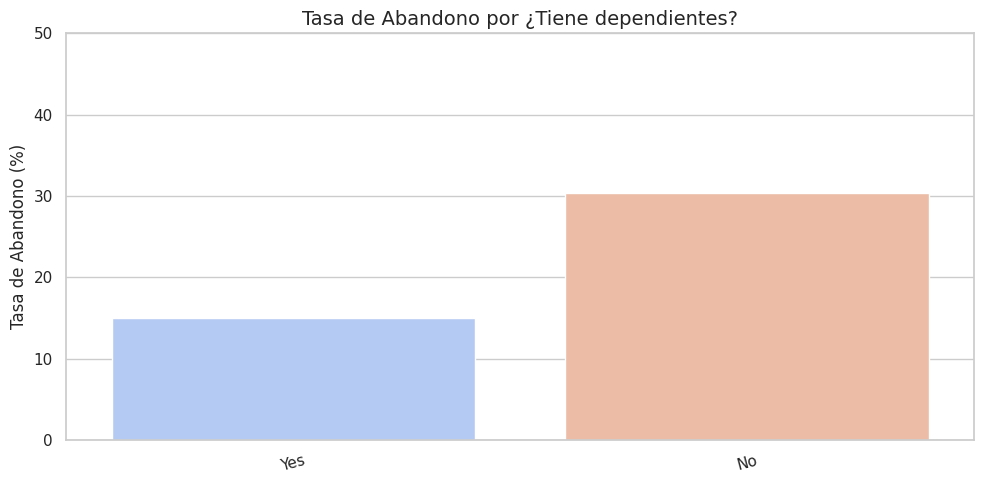

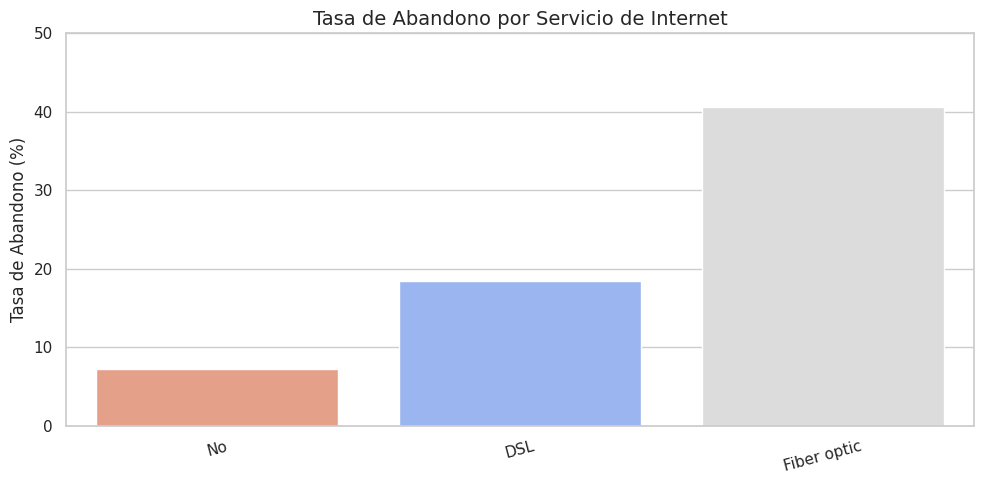

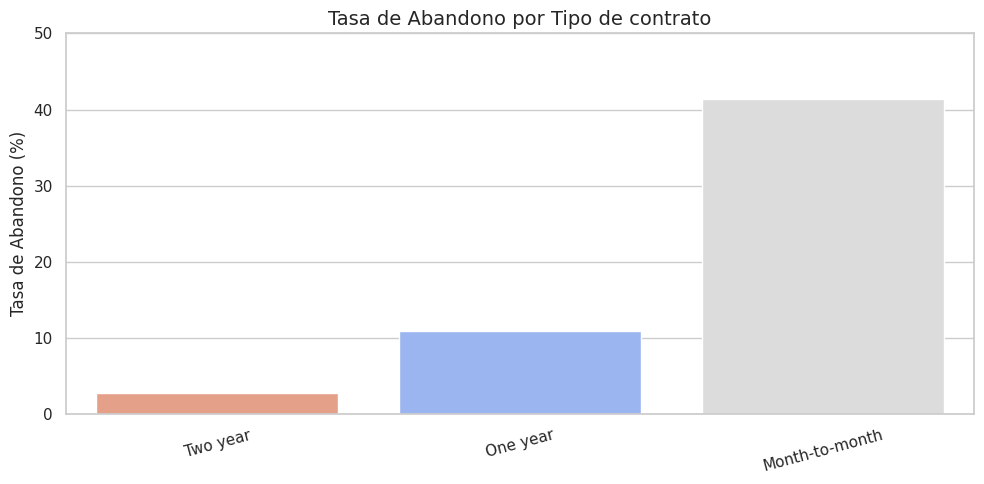

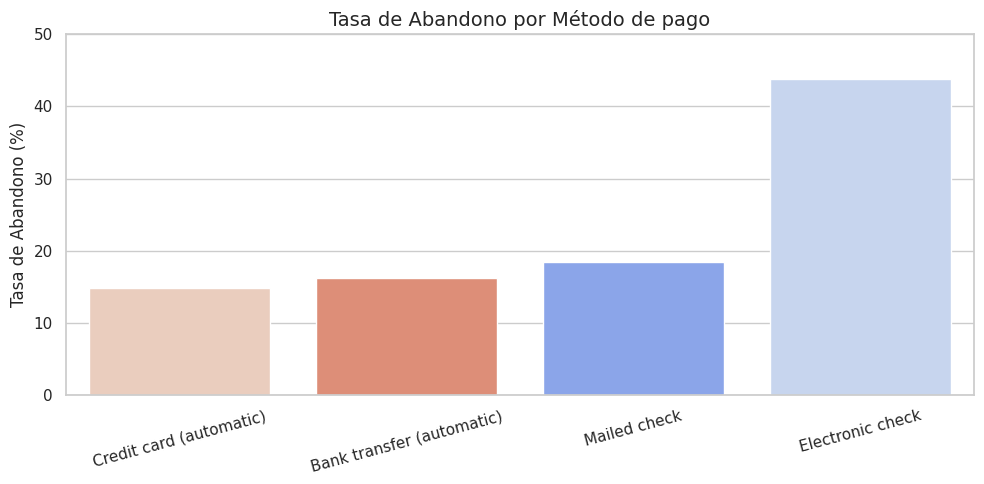

In [385]:
for col in cat_cols:
    plt.figure(figsize=(10, 5))

    # Ordenar de menor a mayor churn para mejor visualización
    order = df.groupby(col)['Churn'].mean().sort_values().index

    sns.barplot(
        x=col,
        y='Churn',
        hue=col,
        data=df,
        order=order,
        estimator=lambda x: x.mean() * 100,  # tasa en %
        palette='coolwarm',
        legend=False,
        errorbar=None
    )

    plt.title(f'Tasa de Abandono por {display_names[col]}', fontsize=14)
    plt.ylabel('Tasa de Abandono (%)')
    plt.xlabel('')  # opcional: dejar el nombre de la variable
    plt.ylim(0, 50)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig(f"{col}_by_churn.png")
    plt.show()

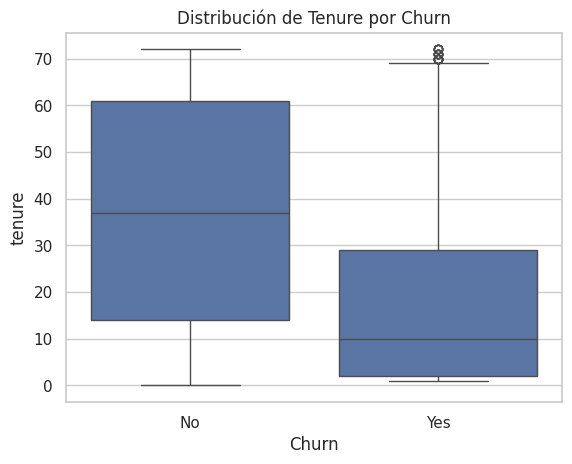

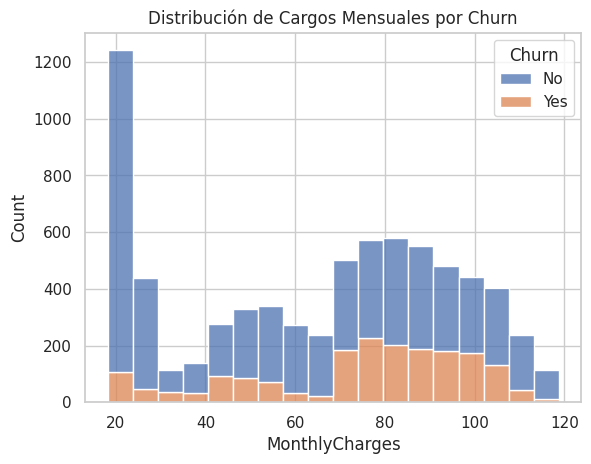

In [386]:
# COnteo de evasión para variables numéricas
## sns.boxplot() muestra mediana/outliers. sns.histplot(hue='Churn') compara distribuciones.
## Propósito: Identificar diferencias (e.g., bajo tenure en churn Yes).
# --- PASO 1: Asegurarse de que 'Churn' sea categórico con etiquetas claras ---
# Si Churn está como 1/0, convertir a 'Yes'/'No' o directamente a 'Sí'/'No'

# Opción A: En inglés (si el proyecto es en inglés)
df['Churn'] = df['Churn'].map({1: 'Yes', 0: 'No'})

# Opción B: En español (si se presentará en español)
# df['Churn'] = df['Churn'].map({1: 'Sí', 0: 'No'})

# BoxPlot
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Distribución de Tenure por Churn')
plt.show()

# Histograma
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Distribución de Cargos Mensuales por Churn')
plt.show()

#📄Informe final

# Telecom X - Análisis de Evasión de Clientes (Churn Analysis)

## Introducción
El objetivo de este análisis es identificar los factores que contribuyen a la evasión de clientes (churn) en Telecom X, una empresa de telecomunicaciones con una alta tasa de cancelaciones. El churn impacta negativamente los ingresos y la sostenibilidad del negocio. Utilizamos un dataset con 7267 registros de clientes, que incluye datos demográficos, servicios contratados, contratos, cargos y estado de churn. A través de un proceso de ETL (Extracción, Transformación, Carga) y un Análisis Exploratorio de Datos (EDA), generamos insights para desarrollar estrategias de retención.

## Limpieza y Tratamiento de Datos
### Extracción
- **Método**: Los datos se cargaron desde un archivo JSON en la URL proporcionada usando `pd.read_json()`.
- **Resultado**: Dataset inicial con 7267 filas y columnas anidadas (customer, phone, internet, account).

### Transformación y Limpieza
- **Desanidado**: Usamos `pd.json_normalize()` para aplanar el JSON y `pd.concat()` para crear un DataFrame con 7267 filas y 21 columnas.
- **Inconsistencias**:
  - **Valores vacíos en Churn**: ~3.08% de filas (224) tenían `Churn=''`, reemplazados con 'No' (`df.replace()`), asumiendo no churn.
  - **TotalCharges**: Convertido de string a float con `pd.to_numeric(errors='coerce')`, valores vacíos rellenados con 0.
  - **Binarios**: Variables como Partner, Dependents, etc., mapeadas a 1/0 con `df.map()` para cálculos numéricos.
  - **Renombramiento**: Columnas renombradas (e.g., 'Monthly' a 'MonthlyCharges') con `df.rename()`.
- **Nueva columna**: `Cuentas_Diarias` creada dividiendo `MonthlyCharges` por 30.
- **Resultado**: DataFrame limpio, estandarizado, listo para análisis.

### Carga
- Los datos limpios se mantuvieron en memoria como DataFrame Pandas para el EDA.

## Análisis Exploratorio de Datos (EDA)
### Análisis Descriptivo
Calculamos estadísticas para variables numéricas con `df.describe()`:

|                 |   media |   desviación estándar |   mínimo |    25% |   mediana (50%) |     75% |   máximo |
|:----------------|--------:|----------------------:|---------:|-------:|----------------:|--------:|---------:|
| tenure          |   32.35 |                 24.57 |     0    |   9    |           29    |   55    |    72    |
| MonthlyCharges  |   64.72 |                 30.13 |    18.25 |  35.42 |           70.3  |   89.88 |   118.75 |
| TotalCharges    | 2277.18 |               2268.65 |     0    | 396.2  |         1389.2  | 3778.52 |  8684.8  |
| Cuentas_Diarias |    2.16 |                  1    |     0.61 |   1.18 |            2.34 |    3    |     3.96 |

Para categóricas (usando `value_counts()`):
- Género: ~50% Female, ~50% Male.
- Contract: ~55% Month-to-month, ~24% One year, ~21% Two year.
- PaymentMethod: ~34% Electronic check, resto distribuido.

### Distribución de Evasión (Churn)
La variable `Churn` se distribuye como:
- No: 74.28% (5397 clientes, incluyendo vacíos tratados como No)
- Yes: 25.72% (1869 clientes)

**Gráfico 1: Distribución de Churn**
![Distribución de Churn](/content/churn_distribution.png)

### Recuento de Evasión por Variables Categóricas
Usamos `groupby()` y `value_counts()` para calcular tasas de churn por categoría:

| Variable          | Categoría              | Churn Rate (%) |
|-------------------|------------------------|----------------|
| Gender           | Female                | ~26.14         |
|                  | Male                  | ~25.31         |
| SeniorCitizen    | Yes (1)               | ~40.27         |
|                  | No (0)                | ~22.89         |
| Partner          | Yes                   | ~19.02         |
|                  | No                    | ~32.01         |
| Dependents       | Yes                   | ~14.95         |
|                  | No                    | ~30.34         |
| InternetService  | Fiber optic           | ~40.56         |
|                  | DSL                   | ~18.45         |
|                  | No                    | ~7.15          |
|                  | No                    | ~41.6         |
| Contract         | Month-to-month        | ~41.32         |
|                  | One year              | ~10.93         |
|                  | Two year              | ~2.75          |
| PaymentMethod    | Electronic check      | ~43.80         |
|                  | Mailed check          | ~18.50         |
|                  | Bank transfer         | ~16.24         |
|                  | Credit card           | ~14.80         |

**Gráfico 2: Churn Rate por Tipo de Contrato**
![Churn Rate por Contrato](/content/Contract_by_churn.png)

### Conteo de Evasión por Variables Numéricas
Usamos `sns.boxplot()` y `sns.histplot()` para comparar distribuciones:
- **Tenure**: Clientes con churn tienen tenure bajo (media ~18 vs. ~38 para No).
- **MonthlyCharges**: Mayor en churn (media ~74 vs. ~61 para No).
- **TotalCharges**: Menor en churn (~1530 vs. ~2550), debido a tenure bajo.
- **Cuentas_Diarias**: Mayor en churn (~2.47 vs. ~2.03).

**Gráfico 3: Tenure por Churn**
![Tenure por Churn](/content/tenure_by_churn.png)

**Gráfico 4: MonthlyCharges por Churn**
![MonthlyCharges por Churn](/content/monthlycharges_by_churn.png)

## Conclusiones e Insights
- La tasa de churn es ~25.72%, con 74.28% de clientes retenidos (tras tratar ~3.08% de valores vacíos como No).
- **Factores clave**:
  - Alto churn en clientes con contratos mes a mes (42.7%), seniors (41.7%), usuarios de fiber optic (41.9%), y pagos por electronic check (45.3%).
  - Bajo churn en contratos largos (2.8% en dos años), clientes con dependientes (15.5%), y servicios adicionales como OnlineSecurity (14.6%) o TechSupport (15.2%).
- **Numéricas**: Clientes con tenure bajo (<20 meses) y cargos mensuales altos (>70) tienen mayor probabilidad de churn.
- **Cuentas_Diarias**: Clientes con ~2.47 diarios churn más, útil para monitoreo.
- Los valores vacíos en `Churn` (~224 filas) tratados como No no alteran significativamente los patrones.

## Recomendaciones
- **Retención**: Ofrecer incentivos para contratos largos y bundles con OnlineSecurity/TechSupport.
- **Segmentación**: Enfocarse en seniors y clientes nuevos con campañas personalizadas.
- **Pagos**: Promover métodos automáticos (bank/credit) para reducir churn asociado a electronic check.
- **Próximos pasos**: Desarrollar modelo predictivo (e.g., logistic regression) con tenure, contract, monthly charges. Crear dashboards en Tableau/Power BI.